<a href="https://colab.research.google.com/github/s-omidikia/computer-vision/blob/main/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Image Segmentation Using U-Net With CelebAMask-HQ Dataset.** 

##**Import TensorFlow and other libraries**

In [ ]:
import cv2
import glob
import numpy as np
import tensorflow as tf
from google.colab import drive
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import History
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Set up the input pipeline**

###**Load the dataset**

In [ ]:
!unzip -q /content/gdrive/MyDrive/celebAmask.zip -d celebAmask

In [ ]:
images_path = '/content/celebAmask/images/*'
mask1_path = '/content/celebAmask/hair_masks/*'
mask2_path = '/content/celebAmask/skin_masks/*'
image_files = sorted(glob.glob(images_path))
mask1_files = sorted(glob.glob(mask1_path))
mask2_files = sorted(glob.glob(mask2_path))

###**Splitting dataset into training and test set**

In [ ]:
m = int(0.8*len(image_files))
images_train, masks1_train, masks2_train = image_files[:m], mask1_files[:m], mask2_files[:m] 
images_test, masks1_test, masks2_test  = image_files[m:],  mask1_files[m:], mask2_files[m:]
train_files = list(zip(images_train, masks1_train, masks2_train))
test_files = list(zip(images_test, masks1_test, masks2_test))

**Setting some hyperparameters:**

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 50
IMG_WIDTH = 256
IMG_HEIGHT = 256

###**Defining some functions for reading data and preprocessing.**

In [ ]:
def load(files):

  #reading files
  image_file, mask1_file, mask2_file = files[0][0],files[0][1],files[0][2]

  #reading image
  image = tf.io.read_file(image_file)
  #returns a tensor of type uint8 and with channels = 3 outputs an RGB image.
  image = tf.image.decode_jpeg(image, channels = 3)
  image = tf.cast(image, tf.float32)

  #reading mask1
  mask1 = tf.io.read_file(mask1_file)
  #returns a tensor of type uint8 and with channels = 1 outputs a grayscale image.
  mask1 = tf.image.decode_png(mask1, channels = 1)
  mask1 = tf.cast(mask1, tf.float32)
  mask1 = tf.reshape(mask1,tf.shape(mask1))

  #reading mask2
  mask2 = tf.io.read_file(mask2_file)
  #returns a tensor of type uint8 and with channels = 1 outputs a grayscale image.
  mask2 = tf.image.decode_png(mask2, channels = 1)
  mask2 = tf.cast(mask2, tf.float32)
  mask2 = tf.reshape(mask2,tf.shape(mask2))

  #mapping masks to class indices(mask1)
  indices_to_change1 = mask1==255.
  idx_change1 = tf.where( indices_to_change1 == True )
  values_change1 = tf.tile( [1.], [tf.shape(idx_change1)[0]] )
  logits_change1 = tf.sparse.reorder (tf.SparseTensor( idx_change1, values_change1, tf.shape(mask1, out_type = tf.int64)))
  final_mask1 = tf.sparse.to_dense(logits_change1, default_value = 0.)

  #mapping masks to class indices(mask2)
  indices_to_change2 = mask2==255.
  idx_change2 = tf.where( indices_to_change2 == True )
  values_change2 = tf.tile( [1.], [tf.shape(idx_change2)[0]] )
  logits_change2 = tf.sparse.reorder (tf.SparseTensor( idx_change2, values_change2, tf.shape(mask2, out_type = tf.int64)))
  final_mask2 = tf.sparse.to_dense(logits_change2, default_value = 0.)

  ##creating background
  m1 = final_mask1 + final_mask2
  indices_to_change3 = m1==0.
  idx_change3 = tf.where( indices_to_change3 == True )
  values_change3 = tf.tile( [1.], [tf.shape(idx_change3)[0]] )
  logits_change3 = tf.sparse.reorder (tf.SparseTensor( idx_change3, values_change3, tf.shape(mask2, out_type = tf.int64)))
  final_mask3 = tf.sparse.to_dense(logits_change3, default_value = 0.)

  #solving problem of overlapping between the hair mask(mask1) and the skin mask(mask2).  
  indices_to_change4 = m1==2.
  idx_change4 = tf.where( indices_to_change4 == True )
  values_change4 = tf.tile( [1.], [tf.shape(idx_change4)[0]] )
  logits_change4 = tf.sparse.reorder (tf.SparseTensor( idx_change4, values_change4, tf.shape(mask2, out_type = tf.int64)))
  final_mask4 = tf.sparse.to_dense(logits_change4, default_value = 0.)

  #creating target mask
  mask = tf.concat((final_mask1,final_mask2-final_mask4,final_mask3),axis=2)

  return image, mask

def resize(image, mask, height, width):
  IMG_WIDTH = 256
  IMG_HEIGHT = 256
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return image, mask

def random_crop(image, mask):
  cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image, mask

@tf.function()
def random_jitter(image, mask):
  # resizing to 286 x 286 x 3
  image, mask = resize(image, mask, 286, 286)
  # randomly cropping to 256 x 256 x 3
  image, mask = random_crop(image, mask)
  # random mirroring
  image = tf.image.random_flip_left_right(image)
  return image, mask

def normalize(image, mask):
  image = tf.cast(image, tf.float32) / 255.0
  mean = tf.reduce_mean(image)
  std = tf.math.reduce_std(image)
  image = (image - mean) / std
  return image, mask

@tf.function()
def preprocess_train(files):
  image, mask = load(files)
  image, mask = normalize(image, mask)
  image, mask = random_jitter(image, mask)
  return image, mask

def preprocess_test(files):
  image, mask = load(files)
  image, mask = normalize(image, mask)
  image, mask = resize(image, mask, IMG_HEIGHT, IMG_WIDTH)
  return image, mask

###**Input pipeline**

**Creating dataset and applying preprocessing steps:**

The tf.data.Dataset API supports writing descriptive and efficient input pipelines.To do so, we first create a source dataset from the input data.
and then apply dataset transformations to preprocess the data.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices(train_files).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices(test_files).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_ds = train_ds.map(
    preprocess_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_ds = test_ds.map(
    preprocess_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

##**Loss Function**
We use multi-dimensional Dice coefficient loss for our multi-class segmentation task.





In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

opt = Adam(1e-4)

##**Create the model**

In [ ]:
def get_unet(img_rows, img_cols):
    inputs = Input((img_rows, img_cols, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(3, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=opt, loss=dice_coef_loss, metrics=[dice_coef])

    return model



In [ ]:
model = get_unet(256, 256)
model.summary()
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

**Showing two examples in the training set**

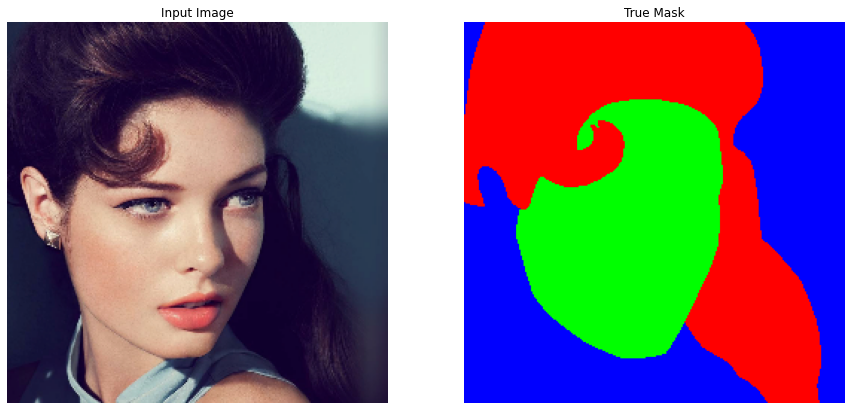

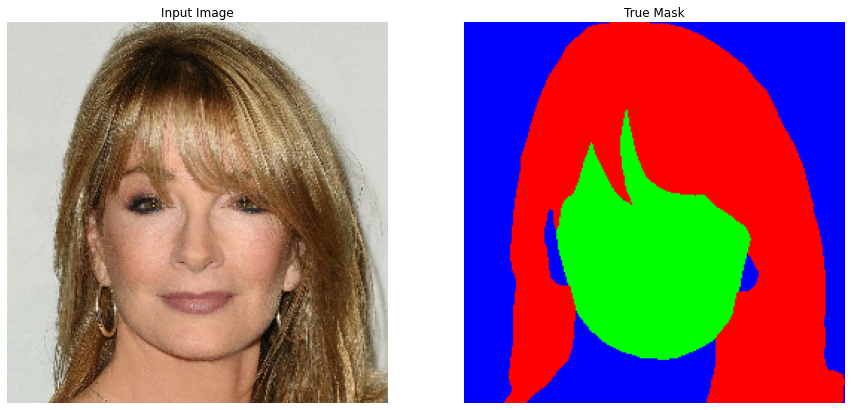

In [ ]:
for images, masks in train_ds.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

###**Prediction before training**

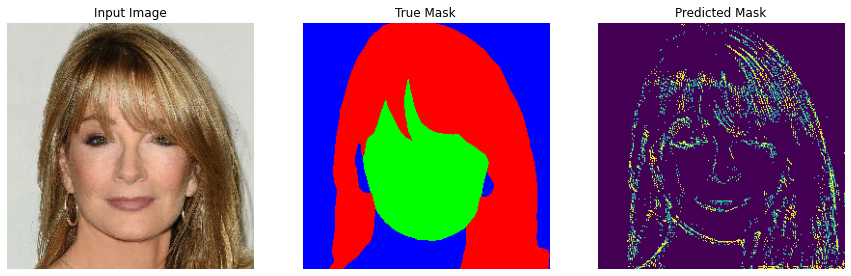

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

##**Training**

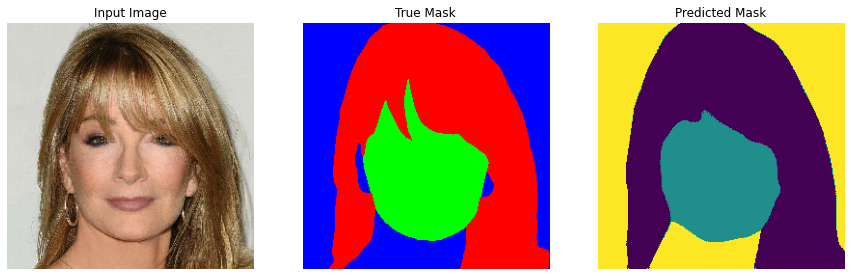


Sample Prediction after epoch 150

2/2 [==============================] - 2s 673ms/step - loss: -0.9201 - dice_coef: 0.9201 - val_loss: -0.8599 - val_dice_coef: 0.8599


In [ ]:
EPOCHS = 150
history = model.fit(train_ds, batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=True, validation_data=test_ds,callbacks=[DisplayCallback()])

##**Visualization of results**

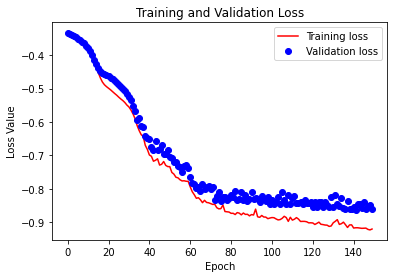

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
#plt.ylim([0, 1])
plt.legend()
plt.show()

##**Make predictions**

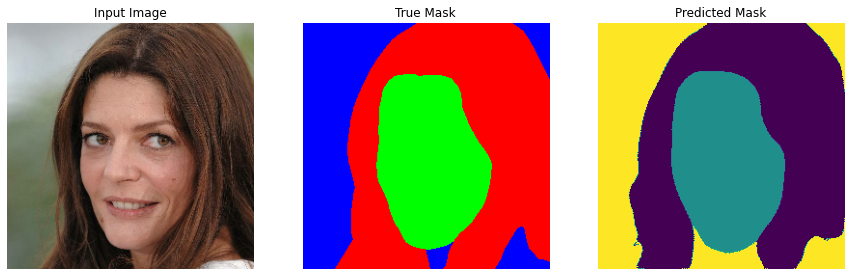

In [ ]:
show_predictions(test_ds, 3)